# Data processing for Dehesa

# Setup
## Library import
We import all the required Python libraries

In [266]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm
import json

# Data import
## Raster data
### Fire danger indicators
**Read data** 

In [238]:
data_dir = '../../datasets/raw/climate/dataset-sis-tourism-fire-danger-indicators/'
for ns, scenario in enumerate(['rcp45', 'rcp85']):
    for n, file in enumerate([i for i in os.listdir(data_dir) if scenario in i]):
        # convert to Dataset and concatenate by time
        if n == 0:
            ds_fire_sce = xr.open_dataset(data_dir+file, engine="netcdf4")
            # add scenario coordinate
            ds_fire_sce = ds_fire_sce.assign_coords({"scenario": scenario})
        else:
            ds = xr.open_dataset(data_dir+file, engine="netcdf4")
            # add scenario coordinate
            ds = ds.assign_coords({"scenario": scenario})
            ds_fire_sce = xr.concat([ds_fire_sce, ds], dim='time')
            
    if ns == 0:
        ds_fire = ds_fire_sce.copy()
    else:
        ds_fire = xr.concat([ds_fire, ds_fire_sce.copy()], dim='scenario')
        
ds_fire

<xarray.Dataset>
Dimensions:        (time: 93, rlon: 424, rlat: 412, scenario: 2, bnds: 2)
Coordinates:
  * time           (time) datetime64[ns] 2005-11-01 2006-11-01 ... 2097-11-01
  * rlon           (rlon) float64 -28.38 -28.27 -28.16 ... 17.94 18.05 18.16
  * rlat           (rlat) float64 -23.38 -23.27 -23.16 ... 21.62 21.73 21.84
    lon            (rlat, rlon) float64 -10.06 -9.964 -9.864 ... 64.76 64.96
    lat            (rlat, rlon) float64 21.99 22.03 22.07 ... 66.81 66.75 66.69
  * scenario       (scenario) <U5 'rcp45' 'rcp85'
Dimensions without coordinates: bnds
Data variables:
    rotated_pole   (scenario, time) |S1 b'' b'' b'' b'' b'' ... b'' b'' b'' b''
    time_bnds      (scenario, time, bnds) datetime64[ns] 2005-11-01 ... 2098-...
    fwi-mean-jjas  (scenario, time, rlat, rlon) float64 59.63 61.19 ... 3.144
Attributes: (12/13)
    creation_date:  2019-06-19-T09:10:38Z
    Frequency:      Annual
    institution:    National Observatory of Athens, URL: http://www.noa.gr
    contact:        cgiannak@noa.gr
    title:          fwi-mean-jjas
    references:     van Wagner, C. E., (1987). Development and structure of a...
    ...             ...
    history:        Version: 0.01
    Lineage:        
    Summary:        
    Keywords:       
    comment:        None
    License:        License to Use Copernicus Products

**Clip area**

Bounding box spain:

In [239]:
x_min, y_min, x_max, y_max = (-25, -15, -10, -3)

ds_fire = ds_fire.sel(rlon=slice(x_min, x_max), rlat=slice(y_min, y_max)).copy()

**Resample time**

In [240]:
ds_fire = ds_fire.assign_coords({"time": pd.DatetimeIndex(ds_fire.time.values).year+1})

da_fire = ds_fire['fwi-mean-jjas'].copy()
attrs = ds_fire.attrs
for n, years in enumerate([[2006,2020], [2021, 2040], [2041, 2060], [2061, 2080], [2081, 2098]]):
    da_fire_sce = da_fire.sel(time=slice(years[0],years[1])).mean('time').assign_coords({"time": f'{years[0]}-{years[1]}'})
    
    if n == 0:
        da = da_fire_sce.copy()
    else:
        da = xr.concat([da, da_fire_sce.copy()], dim='time')
        
ds_fire = da.to_dataset().assign_attrs(attrs)
ds_fire

<xarray.Dataset>
Dimensions:        (rlon: 137, rlat: 109, scenario: 2, time: 5)
Coordinates:
  * rlon           (rlon) float64 -24.96 -24.86 -24.75 ... -10.23 -10.11 -10.0
  * rlat           (rlat) float64 -14.9 -14.79 -14.69 ... -3.245 -3.135 -3.025
    lon            (rlat, rlon) float64 -10.43 -10.31 -10.2 ... 3.023 3.18 3.338
    lat            (rlat, rlon) float64 31.04 31.08 31.12 ... 46.69 46.71 46.73
  * scenario       (scenario) <U5 'rcp45' 'rcp85'
  * time           (time) <U9 '2006-2020' '2021-2040' ... '2081-2098'
Data variables:
    fwi-mean-jjas  (time, scenario, rlat, rlon) float64 nan nan ... 11.44 10.75
Attributes: (12/13)
    creation_date:  2019-06-19-T09:10:38Z
    Frequency:      Annual
    institution:    National Observatory of Athens, URL: http://www.noa.gr
    contact:        cgiannak@noa.gr
    title:          fwi-mean-jjas
    references:     van Wagner, C. E., (1987). Development and structure of a...
    ...             ...
    history:        Version: 0.01
    Lineage:        
    Summary:        
    Keywords:       
    comment:        None
    License:        License to Use Copernicus Products

**Display data**

/opt/conda/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)


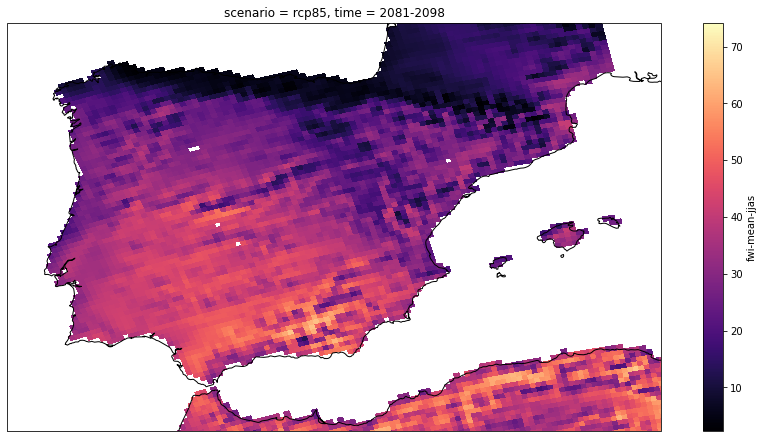

In [241]:
fig, ax = plt.subplots(figsize=(15,7.5))

ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_global()

ds_fire['fwi-mean-jjas'].isel(time=-1).sel(scenario='rcp85').plot.pcolormesh(ax=ax, cmap='magma', transform=ccrs.PlateCarree(), x='lon', y='lat', add_colorbar=True)
ax.coastlines()

lon_min, lat_min, lon_max, lat_max = (-9.39288367353, 35.946850084, 4.32841, 43.7483377142)
ax.set_ylim([lat_min-1,lat_max+1]);
ax.set_xlim([lon_min-1,lon_max+1]);

### Dry spells
**Read data** 

In [242]:
data_dir = '../../datasets/raw/climate/dataset-sis-biodiversity-cmip5-regional/'
for ns, scenario in enumerate(['rcp45', 'rcp85']):
    print(scenario)
    for n, file in enumerate([i for i in os.listdir(data_dir) if scenario in i]):
        print(file)
        if n == 0:
            ds_bio_sce = xr.open_dataset(data_dir+file, engine="netcdf4")
        else:
            if 'dry-spells_maximum-length' in file:
                # Ingest the dry spells variables as float32 and not as timedelta64
                raw = xr.open_dataset(data_dir+file, engine="netcdf4", decode_cf=False)
                del raw['dry-spells_maximum-length'].attrs['units']
                ds = xr.decode_cf(raw)
            else:
                ds = xr.open_dataset(data_dir+file, engine="netcdf4")
                
            # Assign new data variables to a Dataset
            ds_bio_sce = ds_bio_sce.assign({list(ds.keys())[-1]: ds[list(ds.keys())[-1]]})
            # Add scenario coordinate
            ds_bio_sce = ds_bio_sce.assign_coords({"scenario": scenario})
            
    if ns == 0:
        ds_bio = ds_bio_sce.copy()
    else:
        ds_bio = xr.concat([ds_bio.drop_vars('height'), ds_bio_sce.copy()], dim='scenario')

# Rename longitude/latitude to lon/lat
ds_bio = ds_bio.rename({"longitude": "lon", "latitude": "lat"})

ds_dry = ds_bio['dry-spells_maximum-length'].to_dataset()
ds_dry

rcp45
aridity_wettest-quarter_noresm1-m_rcp45_r1i1p1_1960-2099-mean_v1.0.nc
BIO16_noresm1-m_rcp45_r1i1p1_1960-2099-mean_v1.0.nc
dry-spells_maximum-length_noresm1-m_rcp45_r1i1p1_1960-2099-mean_v1.0.nc
BIO12_noresm1-m_rcp45_r1i1p1_1960-2099-mean_v1.0.nc
rcp85
BIO12_noresm1-m_rcp85_r1i1p1_1960-2099-mean_v1.0.nc
aridity_wettest-quarter_noresm1-m_rcp85_r1i1p1_1960-2099-mean_v1.0.nc
BIO16_noresm1-m_rcp85_r1i1p1_1960-2099-mean_v1.0.nc
dry-spells_maximum-length_noresm1-m_rcp85_r1i1p1_1960-2099-mean_v1.0.nc


<xarray.Dataset>
Dimensions:                    (lat: 4800, lon: 9600, time: 7, scenario: 2)
Coordinates:
  * lat                        (lat) float64 32.0 32.01 32.02 ... 71.99 72.0
  * lon                        (lon) float64 -30.0 -29.99 -29.98 ... 49.99 50.0
  * time                       (time) datetime64[ns] 1979-01-01 ... 2090-01-01
  * scenario                   (scenario) <U5 'rcp45' 'rcp85'
Data variables:
    dry-spells_maximum-length  (scenario, time, lat, lon) float32 52.29 ... 2...

**Clip area**

Bounding box spain:

In [243]:
lon_min, lat_min, lon_max, lat_max = (-9.39288367353, 35.946850084, 4.32841, 43.7483377142)

In [244]:
ds_dry = ds_dry.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max)).copy()
ds_dry

<xarray.Dataset>
Dimensions:                    (lat: 936, lon: 1646, time: 7, scenario: 2)
Coordinates:
  * lat                        (lat) float64 35.95 35.96 35.97 ... 43.74 43.75
  * lon                        (lon) float64 -9.387 -9.379 ... 4.312 4.321
  * time                       (time) datetime64[ns] 1979-01-01 ... 2090-01-01
  * scenario                   (scenario) <U5 'rcp45' 'rcp85'
Data variables:
    dry-spells_maximum-length  (scenario, time, lat, lon) float32 116.4 ... 44.8

**Resample time**

In [245]:
ds_dry = ds_dry.assign_coords({"time": [1980, 1990, 2010, 2030, 2050, 2070, 2090]})
ds_dry = ds_dry.assign_coords({"time": np.array([f"{str(x-9)} - {str(x+10)}" for x in ds_dry.time.data])})
ds_dry

<xarray.Dataset>
Dimensions:                    (lat: 936, lon: 1646, time: 7, scenario: 2)
Coordinates:
  * lat                        (lat) float64 35.95 35.96 35.97 ... 43.74 43.75
  * lon                        (lon) float64 -9.387 -9.379 ... 4.312 4.321
  * time                       (time) <U11 '1971 - 1990' ... '2081 - 2100'
  * scenario                   (scenario) <U5 'rcp45' 'rcp85'
Data variables:
    dry-spells_maximum-length  (scenario, time, lat, lon) float32 116.4 ... 44.8

**Display data**

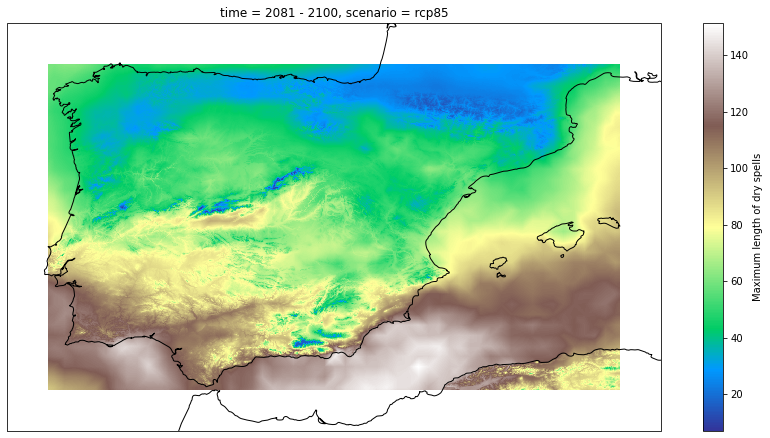

In [246]:
fig, ax = plt.subplots(figsize=(15,7.5))

ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_global()

ds_dry['dry-spells_maximum-length'].isel(time=-1).sel(scenario='rcp85').plot.pcolormesh(ax=ax, cmap='terrain', transform=ccrs.PlateCarree(), x='lon', y='lat', add_colorbar=True)
ax.coastlines()

lon_min, lat_min, lon_max, lat_max = (-9.39288367353, 35.946850084, 4.32841, 43.7483377142)
ax.set_ylim([lat_min-1,lat_max+1]);
ax.set_xlim([lon_min-1,lon_max+1]);

**Put all raster data together** 

In [247]:
ds_rasters = {"Fire danger indicator": ds_fire,
             "Bioclimatic indicators": ds_dry}

## Vector data 
### Spain
**Read data**

In [248]:
spain = gpd.read_file('../../datasets/processed/spain.geojson', driver='GeoJSON')

### Provincias
**Read data**

In [249]:
provincias = gpd.read_file(f'../../datasets/raw/georegions/Provincias/Provincias.shp')
provincias.sort_values(['CO_CCAA', 'CO_PROVINC'], inplace = True)

### Mapa de cultivos
**Read data**

In [15]:
gdf_corine = gpd.read_file('../../datasets/raw/crops/CLC2018_GDB/CLC2018_ES.gdb', driver="FileGDB", layer='CLC18_ES')
# Re-Project
gdf_corine = gdf_corine.to_crs("EPSG:4326")
gdf_corine = gdf_corine.set_crs("EPSG:4326")

In [16]:
gdf_dehesa = gdf_corine[gdf_corine['CODE_18'].isin(['244'])].copy()

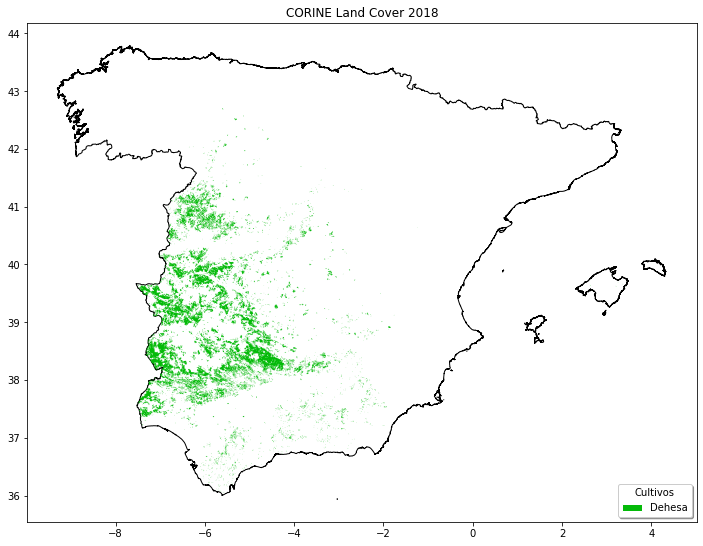

In [17]:
fig, ax = plt.subplots(figsize=(12,12))

spain.plot(ax=ax, color='w', edgecolor='k')
gdf_dehesa.plot(ax=ax, color='#04BA09', label= 'Dehesa', legend=True)

ax.set_title('CORINE Land Cover 2018')

# Adding custom legend

pmark = mpatches.Patch(facecolor='#04BA09',
                       edgecolor='white',
                       linestyle='-',
                       alpha=1,
                       label='Dehesa')


handles, _ = ax.get_legend_handles_labels()
ax.legend(
    handles=[
        *handles,
        pmark,
    ],
    title="Cultivos",
    loc='lower right',
    ncol=1,
    shadow=True)

# show figure
plt.rcParams['legend.title_fontsize'] = 10
plt.show()

#### **Extensión**
**España**

In [18]:
print(f"Extensión total españa {gdf_dehesa['AREA_HA'].sum()}")

Extensión total españa 2376434.3774871975


**Extremadura**

In [19]:
provincias[provincias['DS_CCAA'] == 'Extremadura'].dissolve(by='DS_CCAA').geometry
gdf_dehesa_ext = gdf_dehesa[gdf_dehesa.intersects(provincias[provincias['DS_CCAA'] == 'Extremadura'].dissolve(by='DS_CCAA').geometry.iloc[0])]
gdf_dehesa_ext.head()

,CODE_18,AREA_HA,Shape_Length,Shape_Area,ID,geometry
105403,244,679.304011,37806.064357,6.793040e+06,105409,"MULTIPOLYGON (((-5.99563 38.00014, -5.99411 37..."
105418,244,25.357353,2596.558063,2.535735e+05,105424,"MULTIPOLYGON (((-6.18725 38.00227, -6.18710 38..."
105436,244,133.608691,13444.824503,1.336087e+06,105442,"MULTIPOLYGON (((-5.96094 38.01744, -5.96117 38..."
105443,244,40.817596,3255.161175,4.081760e+05,105449,"MULTIPOLYGON (((-6.19392 38.01425, -6.19390 38..."
105444,244,30.303912,2982.149390,3.030391e+05,105450,"MULTIPOLYGON (((-5.97108 38.02384, -5.97098 38..."


<AxesSubplot:>

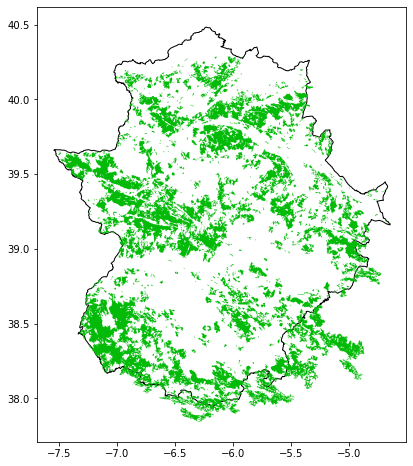

In [20]:
fig, ax = plt.subplots(figsize=(8,8))

provincias[provincias['DS_CCAA'] == 'Extremadura'].dissolve(by='DS_CCAA').plot(ax=ax, color='w', edgecolor='k')
gdf_dehesa_ext.plot(ax=ax, color='#04BA09', label= 'Dehesa', legend=True)


In [21]:
print(f"Extensión total Extremadura {gdf_dehesa_ext['AREA_HA'].sum()}")

Extensión total Extremadura 1289815.3266498437


# Zonal statistics
**Get value over time**

In [230]:
gdf_dehesa.reset_index(drop=True)

,ID,dataset,indicator,value,geometry
0,103701,Mapa de cultivos,Localización cultivo,Dehesa,"MULTIPOLYGON (((-5.57217 36.05634, -5.57214 36..."
1,103702,Mapa de cultivos,Localización cultivo,Dehesa,"MULTIPOLYGON (((-5.56852 36.06253, -5.56817 36..."
2,103703,Mapa de cultivos,Localización cultivo,Dehesa,"MULTIPOLYGON (((-5.64160 36.08095, -5.64124 36..."
3,103704,Mapa de cultivos,Localización cultivo,Dehesa,"MULTIPOLYGON (((-5.67913 36.09335, -5.67909 36..."
4,103705,Mapa de cultivos,Localización cultivo,Dehesa,"MULTIPOLYGON (((-5.70005 36.09426, -5.69969 36..."
...,...,...,...,...,...
4890,108593,Mapa de cultivos,Localización cultivo,Dehesa,"MULTIPOLYGON (((-5.29147 42.52059, -5.29159 42..."
4891,108594,Mapa de cultivos,Localización cultivo,Dehesa,"MULTIPOLYGON (((-5.33278 42.53061, -5.33293 42..."
4892,108595,Mapa de cultivos,Localización cultivo,Dehesa,"MULTIPOLYGON (((-5.12737 42.57426, -5.12730 42..."
4893,108596,Mapa de cultivos,Localización cultivo,Dehesa,"MULTIPOLYGON (((-5.58897 42.69291, -5.58868 42..."


In [250]:
def number_of_digits(x):
    """Get number of digits to the left/right of a decimal point"""
    # Number of digits to the left of the decimal point
    dig_left = int(np.log10(x))+1
    # Number of digits to the right of the decimal point
    if '.' in str(x):
        decList = [int(y) for y in list(str(x).split('.')[1])]
        dig_right = next((i for i, x in enumerate(decList) if x), None) + 1
    else:
        dig_right = 0
        
    return dig_left, dig_right

In [232]:
def find_nearest(array, value):
    """Find nearest value in numpy array"""
    array = np.asarray(array)
    
    # Get the mean step values
    step = np.abs(np.diff(array)).max()*1.5
    
    # Find the nearest values
    diff = np.abs(array - value)
    idx = np.argwhere((diff >= np.amin(diff) - step) & (diff <= np.amin(diff) + step))

    return idx

In [234]:
def get_nearest_xy_from_latlon(ds, lat, lon, lon_name='lon', lat_name='lat'):
    """Return the x/y values for a given longitude/latitude values"""
    # Read all lon/lat values
    lons = ds[lon_name].data
    lats = ds[lat_name].data
    
    # Get mean lon/lat step size 
    mean_lat_size = np.abs(np.diff(lats)).mean()
    #print(mean_y_size)
    mean_lon_size = np.abs(np.diff(lons)).mean()
    
    # Round lon/lat values to the first decimal place
    dig_left, dig_right = number_of_digits(mean_lat_size) 
    if dig_right == 0: 
        lat = round(lat)
    else:
        lat = round(lat, dig_right)
        
    dig_left, dig_right = number_of_digits(mean_lon_size) 
    if dig_right == 0: 
        lon = round(lon)
    else:
        lon = round(lon, dig_right)
    
    # Find the positions of the nearest longitude/latitude values
    idx_lon = find_nearest(lons, lon)
    idx_lat = find_nearest(lats, lat)
    
    # Check the identical rows in both arrays
    res = (idx_lon[:, None] == idx_lat).all(-1).any(-1)
    yx_positions = idx_lon[res]
    
    
    if yx_positions.shape[0] == 0:
        raise Exception("Sorry, lat/lon values outside data domain")   
    if yx_positions.shape[0] > 1:
        # If more than one identical rows take the row nearest to the mean value
        yx_positions = np.mean(yx_positions,axis=0).astype(int).reshape(1,2)

    # Get the x/y values
    x_position = yx_positions[0][1]
    y_position = yx_positions[0][0]
    
    x = ds.rlon.data[yx_positions[0][1]]
    y = ds.rlat.data[yx_positions[0][0]]

    return x_position, y_position, x, y

In [235]:
def get_nearest_latlon_from_latlon(ds, lat, lon, lon_name='lon', lat_name='lat'):
    """Return the x/y values for a given longitude/latitude values"""
    # Read all lon/lat values
    lons = ds[lon_name].data
    lats = ds[lat_name].data
    
    # Get mean lon/lat step size 
    mean_lat_size = np.abs(np.diff(lats)).mean()
    #print(mean_y_size)
    mean_lon_size = np.abs(np.diff(lons)).mean()
    
    # Round lon/lat values to the first decimal place
    dig_left, dig_right = number_of_digits(mean_lat_size) 
    if dig_right == 0: 
        lat = round(lat)
    else:
        lat = round(lat, dig_right)
        
    dig_left, dig_right = number_of_digits(mean_lon_size) 
    if dig_right == 0: 
        lon = round(lon)
    else:
        lon = round(lon, dig_right)
    
    # Find the positions of the nearest longitude/latitude values
    lon_positions = find_nearest(lons, lon)
    lat_positions = find_nearest(lats, lat)
    
    # If more than one identical rows take the row nearest to the mean value
    lon_position = round(np.mean(lon_positions))
    lat_position = round(np.mean(lat_positions))

    return lon_position, lat_position

In [236]:
def get_centroid_values(gdf, ds, da, logical_coordinates=False, lon_name='lon', lat_name='lat'):  
    #Add geometries smaller than mean cell size into the mask
    gdf['centroid'] = gdf['geometry'].apply(lambda x: x.centroid)
    
    values = []
    for id_int in tqdm(gdf.index):
        lon = gdf['centroid'].loc[id_int].x
        lat = gdf['centroid'].loc[id_int].y

        if logical_coordinates:
            # Get x/y positions for the corresponding longitude/latitude values
            x_pos, y_pos, x, y = get_nearest_xy_from_latlon(ds, lat, lon, lon_name=lon_name, lat_name=lat_name)
        else:
            # Get longitude/latitude positions for the corresponding longitude/latitude values
            x_pos, y_pos = get_nearest_latlon_from_latlon(ds, lat, lon, lon_name=lon_name, lat_name=lat_name)        
        
        # Replace cell value with new int
        values.append(da.data[:, y_pos, x_pos])
            
    return values

In [251]:
indicators = {"Fire danger indicator": 'fwi-mean-jjas',
             "Bioclimatic indicators": 'dry-spells_maximum-length'}

gdf_indicators = {}

gdf = gdf_dehesa.copy()
#Reset index
gdf = gdf.reset_index(drop=True)

for ds_name, ds in ds_rasters.items():
    print(ds_name)
    indicator = indicators[ds_name]
    gdf_tmp = gdf.copy()
    for scenario in ds.scenario.data:
        print(scenario)
        if ds_name == 'Fire danger indicator':
            centroid_values = get_centroid_values(gdf, ds, ds[indicator].sel(scenario=scenario), logical_coordinates=True, lon_name='lon', lat_name='lat')
        else:
            centroid_values = get_centroid_values(gdf, ds, ds[indicator].sel(scenario=scenario), logical_coordinates=False, lon_name='lon', lat_name='lat')


        df = pd.DataFrame({'index': list(gdf.index),\
                        f'{indicator} ({scenario})': centroid_values,
                        f'{indicator} ({scenario}) (time)': [list(ds.coords['time'].values)]*len(centroid_values)})

        gdf_tmp = pd.merge(gdf_tmp.reset_index(), df, how = 'left', on = 'index').drop(columns='index')

    gdf_indicators[ds_name] = gdf_tmp

Fire danger indicator
rcp45


100%|██████████| 4895/4895 [00:09<00:00, 535.28it/s]


rcp85


100%|██████████| 4895/4895 [00:09<00:00, 540.33it/s]


Bioclimatic indicators
rcp45


100%|██████████| 4895/4895 [00:03<00:00, 1401.13it/s]


rcp85


100%|██████████| 4895/4895 [00:03<00:00, 1418.96it/s]


**Reorganice indicator table**

In [253]:
ds_units = {
'Fire danger indicator': '', 
'Bioclimatic indicators': 'days'
}

df_indicators = {}

for ds_name, gdf in gdf_indicators.items():
    print(ds_name)
    ds = ds_rasters[ds_name].copy()
    indicator = indicators[ds_name]
    gdf_ids = ['ID']
    df = pd.DataFrame(columns=gdf_ids + ['dataset', 'indicator', 'scenario', 'value', 'year'])
    for scenario in ds.scenario.data:
        print(scenario)
        df_tmp = gdf[gdf_ids + [f'{indicator} ({scenario})', f'{indicator} ({scenario}) (time)']].copy()
        df_tmp.rename(columns={f'{indicator} ({scenario})': 'value', f'{indicator} ({scenario}) (time)': 'year'}, inplace=True)
        df_tmp['dataset'] = ds_name
        df_tmp['indicator'] = indicator
        df_tmp['scenario'] = scenario

        # Convert list-like columns (values and years) elements to separate rows
        df_tmp_melt = df_tmp.drop(["year"], axis = 1).copy()

        df_tmp_melt = df_tmp_melt['value'].apply(pd.Series)\
        .merge(df_tmp_melt, right_index = True, left_index = True)\
        .drop(["value"], axis = 1)\
        .reset_index()\
        .melt(id_vars = gdf_ids + ['index', 'dataset', 'indicator', 'scenario'], value_name = "value")\
        .sort_values(['index', 'variable'])\
        .drop(["index", 'variable'], axis = 1)

        df_tmp_melt['year'] = df_tmp['year'].iloc[0]*len(df_tmp)

        df = pd.concat([df, df_tmp_melt])

        df.reset_index(drop=True, inplace=True)
                    
    # Add units
    df['unit'] = ds_units[ds_name]

    df_indicators[ds_name] = df

Fire danger indicator
rcp45
rcp85
Bioclimatic indicators
rcp45
rcp85


In [31]:
df_indicators['Bioclimatic indicators']

,ID,dataset,indicator,scenario,value,year,unit
0,103701,Bioclimatic indicators,dry-spells_maximum-length,rcp45,94.661140,1971 - 1990,days
1,103701,Bioclimatic indicators,dry-spells_maximum-length,rcp45,91.402802,1981 - 2000,days
2,103701,Bioclimatic indicators,dry-spells_maximum-length,rcp45,93.575645,2001 - 2020,days
3,103701,Bioclimatic indicators,dry-spells_maximum-length,rcp45,98.076927,2021 - 2040,days
4,103701,Bioclimatic indicators,dry-spells_maximum-length,rcp45,95.692520,2041 - 2060,days
...,...,...,...,...,...,...,...
68525,108597,Bioclimatic indicators,dry-spells_maximum-length,rcp85,37.955910,2001 - 2020,days
68526,108597,Bioclimatic indicators,dry-spells_maximum-length,rcp85,38.191200,2021 - 2040,days
68527,108597,Bioclimatic indicators,dry-spells_maximum-length,rcp85,38.956425,2041 - 2060,days
68528,108597,Bioclimatic indicators,dry-spells_maximum-length,rcp85,41.680672,2061 - 2080,days


In [255]:
df_indicators['Fire danger indicator']

,ID,dataset,indicator,scenario,value,year,unit
0,103701,Fire danger indicator,fwi-mean-jjas,rcp45,NaN,2006-2020,
1,103701,Fire danger indicator,fwi-mean-jjas,rcp45,NaN,2021-2040,
2,103701,Fire danger indicator,fwi-mean-jjas,rcp45,NaN,2041-2060,
3,103701,Fire danger indicator,fwi-mean-jjas,rcp45,NaN,2061-2080,
4,103701,Fire danger indicator,fwi-mean-jjas,rcp45,NaN,2081-2098,
...,...,...,...,...,...,...,...
48945,108597,Fire danger indicator,fwi-mean-jjas,rcp85,12.721659,2006-2020,
48946,108597,Fire danger indicator,fwi-mean-jjas,rcp85,14.205799,2021-2040,
48947,108597,Fire danger indicator,fwi-mean-jjas,rcp85,16.840866,2041-2060,
48948,108597,Fire danger indicator,fwi-mean-jjas,rcp85,19.344280,2061-2080,


**Save tables**

In [256]:
names = {
'Fire danger indicator': 'fire_danger', 
'Bioclimatic indicators': 'dry_spells'
}
for df_name, df in df_indicators.items():
    df.to_csv(f'../../datasets/processed/dehesa_indicators/dehesa_indicators_{names[df_name]}.csv', index = False)

In [257]:
def reorganize_data(gdf):
    gdf_new = gpd.GeoDataFrame(columns=['ID', 'dataset', 'indicator', 'unit', 'values', 'geometry'])
    for code_id in gdf['ID'].unique():
        LD = json.loads(gdf[gdf['ID'] == code_id][['scenario', 'year', 'value']].to_json(orient='records'))

        v = {k: {dic['year']: dic['value'] for dic in LD if dic['scenario'] == k} for k in ['rcp45', 'rcp85']}

        gdf_tmp = gdf[gdf['ID'] == code_id][['CODE_18', 'ID']].iloc[:1]
        gdf_tmp['dataset'] = gdf['dataset'].iloc[0]
        gdf_tmp['indicator'] = gdf['indicator'].iloc[0]
        gdf_tmp['unit'] = gdf['unit'].iloc[0]
        gdf_tmp['values'] = [v]
        gdf_tmp['geometry'] = gdf[gdf['ID'] == code_id]['geometry'].iloc[:1]

        gdf_new = pd.concat([gdf_new, gdf_tmp])

    return gdf_new

In [262]:
def reorganize_data_new(gdf):
    gdf_new = gpd.GeoDataFrame(columns=['ID', 'dataset', 'indicator', 'unit', 'geometry'])
    for code_id in gdf['ID'].unique():
        df = gdf[gdf['ID'] == code_id][['scenario', 'year', 'value']]

        gdf_tmp = gdf[gdf['ID'] == code_id][['ID']].iloc[:1]
        gdf_tmp['dataset'] = gdf['dataset'].iloc[0]
        gdf_tmp['indicator'] = gdf['indicator'].iloc[0]
        gdf_tmp['unit'] = gdf['unit'].iloc[0]

        columns = []
        for  i in range(len(df)):
            filter = df['year'].iloc[i].replace(" ", "")
            gdf_tmp[f"value_{df['scenario'].iloc[i]}_{filter}"] = df['value'].iloc[i]

        gdf_tmp['geometry'] = gdf[gdf['ID'] == code_id]['geometry'].iloc[:1]

        gdf_new = pd.concat([gdf_new, gdf_tmp])

    return gdf_new

In [263]:
names = {
'Fire danger indicator': 'fire_danger', 
'Bioclimatic indicators': 'dry_spells'
}

for df_name, df in df_indicators.items():
    gdf_tmp = pd.merge(gdf_dehesa[['ID', 'geometry']],  df, on='ID', how='left')
    columns = np.array(gdf_tmp.columns)
    columns = list(np.append(columns[columns != 'geometry'], 'geometry'))
    gdf_tmp = gdf_tmp[columns]

    gdf_tmp = reorganize_data_new(gdf_tmp)

    gdf_tmp.to_file(f"../../datasets/processed/MBTiles/Indicadores_dehesa/dehesa_{names[df_name]}.json", driver="GeoJSON")

**Class values**

In [267]:
gdf = gpd.read_file("../../datasets/processed/MBTiles/Indicadores_dehesa/dehesa_fire_danger.json")
gdf.head()

,ID,dataset,indicator,unit,value_rcp45_2006-2020,value_rcp45_2021-2040,value_rcp45_2041-2060,value_rcp45_2061-2080,value_rcp45_2081-2098,value_rcp85_2006-2020,value_rcp85_2021-2040,value_rcp85_2041-2060,value_rcp85_2061-2080,value_rcp85_2081-2098,geometry
0,103701,Fire danger indicator,fwi-mean-jjas,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((-5.57217 36.05634, -5.57214 36..."
1,103702,Fire danger indicator,fwi-mean-jjas,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((-5.56852 36.06253, -5.56817 36..."
2,103703,Fire danger indicator,fwi-mean-jjas,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((-5.64160 36.08095, -5.64124 36..."
3,103704,Fire danger indicator,fwi-mean-jjas,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((-5.67913 36.09335, -5.67909 36..."
4,103705,Fire danger indicator,fwi-mean-jjas,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((-5.70005 36.09426, -5.69969 36..."


In [280]:
def cat_val(x):
    if x < 5.2:
        return "Muy bajo"
    if (x >= 5.2) and (x < 11.2):
        return "Bajo"
    if (x >= 11.2) and (x < 21.3):
        return "Medio"
    if (x >= 21.3) and (x < 38.0):
        return "Alto"
    if (x >= 38.0) and (x < 50.0):
        return "Muy alto"
    if x >= 50.0:
        return "Extremo"
    else:
        return ""

In [281]:
def cat_none(x):
    if x < 5.2:
        return "Muy bajo"
    if (x >= 5.2) and (x < 11.2):
        return "Bajo"
    if (x >= 11.2) and (x < 21.3):
        return "Medio"
    if (x >= 21.3) and (x < 38.0):
        return "Alto"
    if (x >= 38.0) and (x < 50.0):
        return "Muy alto"
    if x >= 50.0:
        return "Extremo"
    else:
        return ""

In [283]:
cols = list(gdf.columns)
cols = [x for x in cols if 'value' in x]
for col in cols:
    gdf[col] = gdf[col].apply(lambda x: cat_val(x))

In [301]:
gdf.to_file("../../datasets/processed/MBTiles/Indicadores_dehesa/dehesa_fire_danger.json", driver="GeoJSON")

**Display output/input figures**

Fire danger indicator

In [33]:
indicator = 'fwi-mean-jjas'
scenario = 'rcp45'
year = '2061-2080'
df = df_indicators['Fire danger indicator'].copy()

/opt/conda/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)


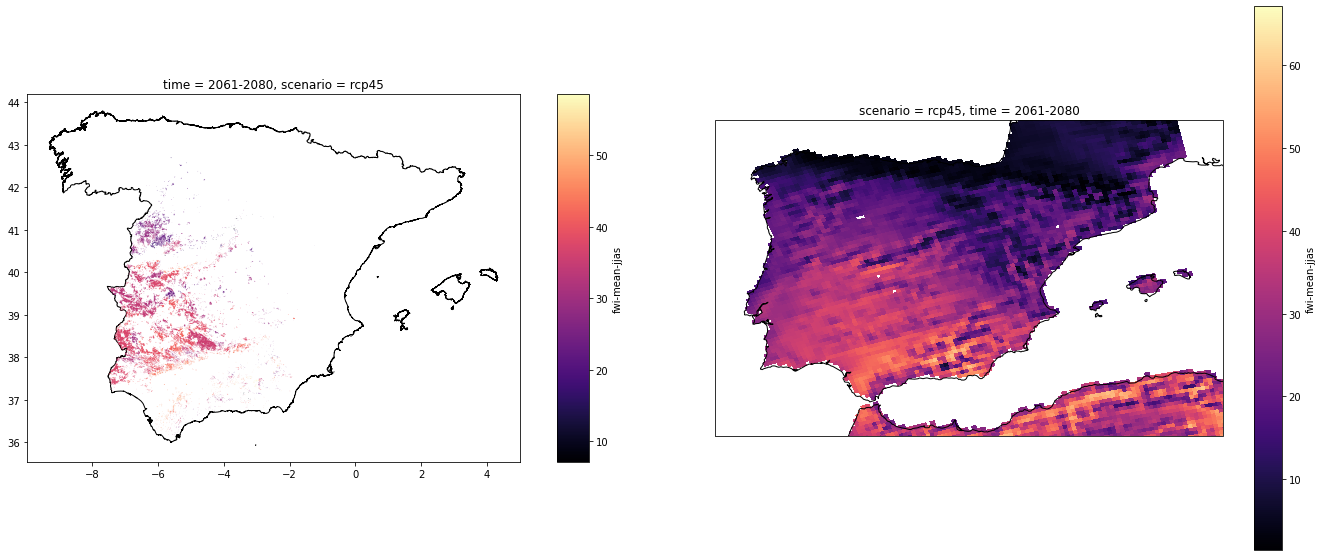

In [34]:
df_tmp = df[(df['scenario'] == scenario) & (df['year'] == year)].copy()

df_tmp = pd.merge(gdf_dehesa,  df_tmp, on='ID', how='left')

fig = plt.figure(figsize=(25,10))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection=ccrs.PlateCarree())

divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=-0.5) 
spain.plot(ax=ax1, color='w', edgecolor='k')
df_tmp.plot(ax=ax1, column='value', cmap='magma', legend=True, cax=cax, legend_kwds={'label': indicator})
ax1.set_title(f'time = {year}, scenario = {scenario}')


ax2.set_global()
ds_fire.sel(scenario=scenario).sel(time=year)[indicator].plot.pcolormesh(ax=ax2, cmap='magma', transform=ccrs.PlateCarree(), x='lon', y='lat', add_colorbar=True)
ax2.coastlines()
ax2.set_ylim([lat_min-1,lat_max+1]);
ax2.set_xlim([lon_min-1,lon_max+1]);

Dry spells 

In [35]:
indicator = 'dry-spells_maximum-length'
scenario = 'rcp45'
year = '2061 - 2080'
df = df_indicators['Bioclimatic indicators'].copy()

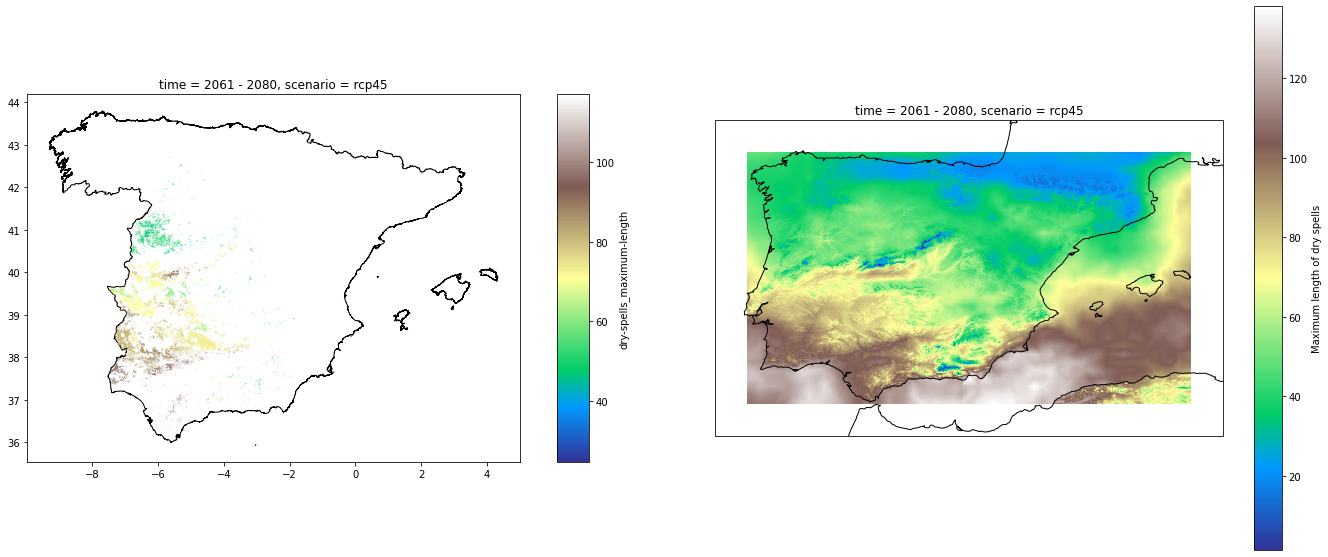

In [36]:
df_tmp = df[(df['scenario'] == scenario) & (df['year'] == year)].copy()

df_tmp = pd.merge(gdf_dehesa,  df_tmp, on='ID', how='left')

fig = plt.figure(figsize=(25,10))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection=ccrs.PlateCarree())

divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=-0.5) 
spain.plot(ax=ax1, color='w', edgecolor='k')
df_tmp.plot(ax=ax1, column='value', cmap='terrain', legend=True, cax=cax, legend_kwds={'label': indicator})
ax1.set_title(f'time = {year}, scenario = {scenario}')


ax2.set_global()
ds_dry.sel(scenario=scenario).sel(time=year)[indicator].plot.pcolormesh(ax=ax2, cmap='terrain', transform=ccrs.PlateCarree(), x='lon', y='lat', add_colorbar=True)
ax2.coastlines()
ax2.set_ylim([lat_min-1,lat_max+1]);
ax2.set_xlim([lon_min-1,lon_max+1]);